W pierwszej kolejności zbuduję autoencoder dla zbioru MNIST

In [12]:
import os
from scipy.stats import norm
import numpy as np
import matplotlib.pyplot as plt


from utils.loaders import load_mnist
from models.AE import Autoencoder

In [3]:
# ustalam parametry
SECTION = 'vae'
RUN_ID = '0001'
DATA_NAME = 'digits'
RUN_FOLDER = 'run/{}/'.format(SECTION)
RUN_FOLDER += '_'.join([RUN_ID, DATA_NAME])

if not os.path.exists(RUN_FOLDER):
    os.mkdir(RUN_FOLDER)
    os.mkdir(os.path.join(RUN_FOLDER, 'viz'))
    os.mkdir(os.path.join(RUN_FOLDER, 'images'))
    os.mkdir(os.path.join(RUN_FOLDER, 'weights'))

MODE =  'build' #'load' #

In [4]:
# pobieramy dane 
(x_train, y_train), (x_test, y_test) = load_mnist()

In [5]:
# definicja struktury autoenkodera
AE = Autoencoder(
    input_dim = (28,28,1)
    , encoder_conv_filters = [32,64,64, 64]
    , encoder_conv_kernel_size = [3,3,3,3]
    , encoder_conv_strides = [1,2,2,1]
    , decoder_conv_t_filters = [64,64,32,1]
    , decoder_conv_t_kernel_size = [3,3,3,3]
    , decoder_conv_t_strides = [1,2,2,1]
    , z_dim = 2
)

if MODE == 'build':
    AE.save(RUN_FOLDER)
else:
    AE.load_weights(os.path.join(RUN_FOLDER, 'weights/weights.h5'))

W0120 22:53:35.099955 38352 module_wrapper.py:139] From E:\Python\Anaconda\envs\generative\lib\site-packages\keras\backend\tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0120 22:53:35.117520 38352 module_wrapper.py:139] From E:\Python\Anaconda\envs\generative\lib\site-packages\keras\backend\tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.



In [6]:
AE.encoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_input (InputLayer)   (None, 28, 28, 1)         0         
_________________________________________________________________
encoder_conv_0 (Conv2D)      (None, 28, 28, 32)        320       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 28, 28, 32)        0         
_________________________________________________________________
encoder_conv_1 (Conv2D)      (None, 14, 14, 64)        18496     
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 14, 14, 64)        0         
_________________________________________________________________
encoder_conv_2 (Conv2D)      (None, 7, 7, 64)          36928     
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 7, 7, 64)          0         
__________

In [7]:
LEARNING_RATE = 0.0005
BATCH_SIZE = 32
INITIAL_EPOCH = 0

In [8]:
AE.compile(LEARNING_RATE)

W0120 22:54:13.462121 38352 module_wrapper.py:139] From E:\Python\Anaconda\envs\generative\lib\site-packages\keras\optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.



In [ ]:
AE.train(     
    x_train[:1000]
    , batch_size = BATCH_SIZE
    , epochs = 200
    , run_folder = RUN_FOLDER
    , initial_epoch = INITIAL_EPOCH
)

In [ ]:
# ładujemy model jeżeli wystartujemy kolejny raz żeby nie trzeba było go trenować za każdym razem
AE = load_model(Autoencoder, RUN_FOLDER)

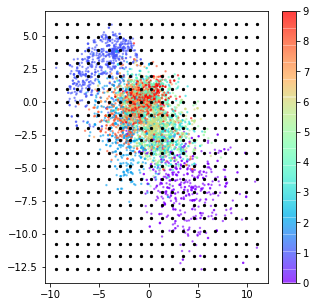

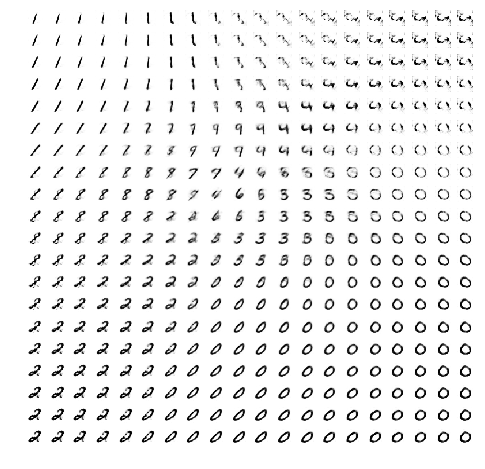

In [15]:
n_to_show = 5000
grid_size = 20
figsize = 8

example_idx = np.random.choice(range(len(x_test)), n_to_show)
example_images = x_test[example_idx]
example_labels = y_test[example_idx]

z_points = AE.encoder.predict(example_images)

plt.figure(figsize=(5, 5))
plt.scatter(z_points[:, 0] , z_points[:, 1] , cmap='rainbow' , c= example_labels
            , alpha=0.5, s=2)
plt.colorbar()

# x = norm.ppf(np.linspace(0.05, 0.95, 10))
# y = norm.ppf(np.linspace(0.05, 0.95, 10))
x = np.linspace(min(z_points[:, 0]), max(z_points[:, 0]), grid_size)
y = np.linspace(max(z_points[:, 1]), min(z_points[:, 1]), grid_size)
xv, yv = np.meshgrid(x, y)
xv = xv.flatten()
yv = yv.flatten()
z_grid = np.array(list(zip(xv, yv)))

reconst = AE.decoder.predict(z_grid)

plt.scatter(z_grid[:, 0] , z_grid[:, 1], c = 'black'#, cmap='rainbow' , c= example_labels
            , alpha=1, s=5)

plt.show()


fig = plt.figure(figsize=(figsize, figsize))
fig.subplots_adjust(hspace=0.4, wspace=0.4)
for i in range(grid_size**2):
    ax = fig.add_subplot(grid_size, grid_size, i+1)
    ax.axis('off')
    ax.imshow(reconst[i, :,:,0], cmap = 'Greys')

In [23]:
display(example_labels)

array([6, 0, 1, ..., 7, 4, 0], dtype=uint8)

In [26]:
# budowa modelu SVM. Zbiorem treningowym będzie warstwa ukryta, zmienną celu natomiast nasza liczba

from sklearn.multiclass import OneVsOneClassifier
from sklearn.svm import SVC

X = z_points
y = example_labels

svm_model = OneVsOneClassifier(SVC(kernel='rbf', gamma = 5, C=0.001))
svm_model.fit(X,y)



OneVsOneClassifier(estimator=SVC(C=0.001, gamma=5))

In [28]:
def plot_predictions(clf, axes):
    x0s = np.linspace(axes[0], axes[1], 100)
    x1s = np.linspace(axes[2], axes[3], 100)
    x0, x1 = np.meshgrid(x0s, x1s)
    Xn = np.c_[x0.ravel(), x1.ravel()]
    y_pred = clf.predict(Xn).reshape(x0.shape)
    y_decision = clf.decision_function(Xn).reshape(x0.shape)
    plt.contourf(x0, x1, y_pred, cmap=plt.cm.brg, alpha=0.2)
    plt.contourf(x0, x1, y_decision, cmap=plt.cm.brg, alpha=0.1)

In [31]:
#plot_predictions(svm_model, [-10.0,10.0, -12.5, 5.0])

x0s = np.linspace(-10.0, 10.0, 100)
x1s = np.linspace(-12.5, 5.0, 100)
x0, x1 = np.meshgrid(x0s, x1s)

In [36]:
Xn = np.c_[x0.ravel(), x1.ravel()]


In [39]:
y_pred = svm_model.predict(Xn).reshape(x0.shape)

In [41]:
x0.shape

(100, 100)

In [ ]:
y_decision = svm_model.decision_function(Xn).reshape(x0.shape)

In [ ]:

y_decision = clf.decision_function(Xn).reshape(x0.shape)
plt.contourf(x0, x1, y_pred, cmap=plt.cm.brg, alpha=0.2)
plt.contourf(x0, x1, y_decision, cmap=plt.cm.brg, alpha=0.1)

ValueError: cannot reshape array of size 100000 into shape (100,100)

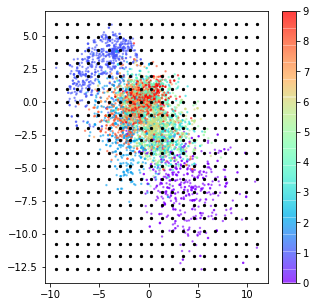

In [29]:

plt.figure(figsize=(5, 5))
plt.scatter(z_points[:, 0] , z_points[:, 1] , cmap='rainbow' , c= example_labels
            , alpha=0.5, s=2)
plt.colorbar()

# x = norm.ppf(np.linspace(0.05, 0.95, 10))
# y = norm.ppf(np.linspace(0.05, 0.95, 10))
x = np.linspace(min(z_points[:, 0]), max(z_points[:, 0]), grid_size)
y = np.linspace(max(z_points[:, 1]), min(z_points[:, 1]), grid_size)
xv, yv = np.meshgrid(x, y)
xv = xv.flatten()
yv = yv.flatten()
z_grid = np.array(list(zip(xv, yv)))

reconst = AE.decoder.predict(z_grid)

plt.scatter(z_grid[:, 0] , z_grid[:, 1], c = 'black'#, cmap='rainbow' , c= example_labels
            , alpha=1, s=5)

plot_predictions(svm_model, [-10.0,10.0, -12.5, 5.0])

plt.show()


fig = plt.figure(figsize=(figsize, figsize))
fig.subplots_adjust(hspace=0.4, wspace=0.4)
for i in range(grid_size**2):
    ax = fig.add_subplot(grid_size, grid_size, i+1)
    ax.axis('off')
    ax.imshow(reconst[i, :,:,0], cmap = 'Greys')